# Shallow Recurrent Decoders (SHRED) for Parametric State Estimation
This notebook demostrates how to combine the *pyforce* package with the [pySHRED](https://github.com/PyShred-Dev/PyShred) and our vanilla implemtation in [NuSHRED](https://github.com/ERMETE-Lab/NuSHRED).

This ML technique is based on the work by [Williams et al. (2024)](https://royalsocietypublishing.org/rspa/article/480/2298/20240054/66770/Sensing-with-shallow-recurrent-decoder), and the extension to parametric problems by [Tomasetto et al. (2025)](https://www.nature.com/articles/s41467-025-65126-y) and [Riva et al. (2025)](https://arxiv.org/abs/2503.08904). 

Two versions of SHRED are available: the official PySHRED package, and the in-house NuSHRED code. The former can be installed via pip:

```bash
pip install pyshred
```
The latter can be cloned from the GitHub repository and the code can be used directly:

```bash
git clone https://github.com/ERMETE-Lab/NuSHRED.git
```

In this notebook, we will consider a parametric flow over cylinder problem, from CFDBench [Luo et al. (2024)](https://arxiv.org/abs/2310.05963): the inlet boundary is parametrized with respect to its intensity, from 0.1 m/s to 1.0 m/s.

At first, let us load the raw snapshots, downloaded from [the benchmark](https://huggingface.co/datasets/chen-yingfa/CFDBench/blob/main/cylinder/bc.zip) - the zenodo folder only contains the first 10 parameters, instead of the full 50.

In [27]:
import numpy as np
import os
from IPython.display import clear_output

folder_to_save = '../Datasets/CFDBenchFlowCyl'

id_cases = [f for f in os.listdir(folder_to_save+'/') if os.path.isdir(os.path.join(folder_to_save+'/', f))]
id_cases.sort()

snap_data = list()
for case_i in range(1, len(id_cases)):
    snap_data.append(dict())

    snap_data[case_i-1]['u'] = np.load(folder_to_save + '/' + id_cases[case_i] + '/u.npy')
    snap_data[case_i-1]['v'] = np.load(folder_to_save + '/' + id_cases[case_i] + '/v.npy')

Nt, Nhx, Nhy = snap_data[0]['u'].shape
Ns = len(snap_data)

var_names = ['u', 'v']

print(f'Number of snapshots: {Ns}, Number of time steps: {Nt}, Grid size: {Nhx} x {Nhy}')

Number of snapshots: 10, Number of time steps: 1000, Grid size: 64 x 64


From the benchmark description, the geometry is generated in the pyvista format.

In [28]:
radius = 0.01
length = 0.16 + 0.06 + 2*radius
height = 2 * 0.06 + 2*radius

import pyvista as pv

x = np.linspace(0, length, Nhx)
y = np.linspace(0, height, Nhy)
X, Y = np.meshgrid(x, y, indexing="ij")
points = np.c_[X.ravel(), Y.ravel(), np.zeros_like(X.ravel())]

# --- Build connectivity for quadrilateral cells ---
# Each quad has 4 vertices, and we store them in the format:
# [4, id0, id1, id2, id3] for each cell
cells = []
for i in range(Nhx - 1):
    for j in range(Nhy - 1):
        p0 = i * Nhy + j
        p1 = p0 + 1
        p2 = p0 + Nhy + 1
        p3 = p0 + Nhy
        cells.append([4, p0, p1, p2, p3])

cells = np.array(cells, dtype=np.int64).ravel()

# Cell types: VTK_QUAD = 9
celltypes = np.full((Nhx - 1) * (Nhy - 1), 9, dtype=np.uint8)

# Plotting the grid
grid = pv.UnstructuredGrid(cells, celltypes, points)
nodes = grid.points[:, :2]  # Extract only x and y coordinates

The snapshots loaded before are the $x$ and $y$ components of the velocity field, parameterised with respect to the inlet velocity. We are going to store them in numpy arrays of the following shape $N_{params}\times N_t\times \mathcal{N}_h$, where $N_{params}$ is the number of parameters (inlet velocities), $N_t$ is the number of time steps, and $\mathcal{N}_h$ is the number of spatial degrees of freedom.

In [29]:
snapshots_np = {var_name: np.zeros((Ns, Nt, Nhx * Nhy)) for var_name in var_names}

for i in range(Ns):
    for var_name in var_names:
        for tt in range(Nt):
            snapshots_np[var_name][i, tt, :] = snap_data[i][var_name][tt].ravel(order='F')

Nh = Nhx * Nhy

from matplotlib import patches
def create_circle(ax):
    radius = 0.01
    center = ((0.06+radius/2), (0.06+radius))
    circle = patches.Ellipse(center, 2*radius, 2*radius, edgecolor='black', facecolor='white', linewidth=2)
    ax.add_patch(circle)

## pySHRED implementation
We first demonstrate the pySHRED implementation using POD-based compressive training, either directly from the package or adopted the functionalities of *pyforce*.

### Directly from pySHRED package
The parametric version has to be loaded.

In [30]:
from pyshred import ParametricDataManager, SHRED, ParametricSHREDEngine

# Initialize ParametricSHREDDataManager
manager_pod = ParametricDataManager(
    lags = 25,
    train_size = 0.8,
    val_size = 0.1,
    test_size = 0.1,
    )

import warnings
warnings.filterwarnings("ignore")

Let us add the different fields, the component $u$ is the one we want to reconstruct, while $v$ is indirectly reconstructed.

In [31]:
# Measured Field
manager_pod.add_data(
    data = snapshots_np['u'],
    id = 'u',
    random = 3,
    compress = 15
)

# Unobserved Field
manager_pod.add_data(
    data = snapshots_np['v'],
    id = 'v',
    compress = 15
)

Here's a summary of the measurements locations

In [32]:
manager_pod.sensor_summary_df

,data id,sensor_number,type,loc/traj
0,u,0,stationary (random),"(3644,)"
1,u,1,stationary (random),"(2751,)"
2,u,2,stationary (random),"(3327,)"


Noise can be added *a-posteriori* to the measurements

In [33]:
noise_std = 0.01
random_noise = np.random.normal(loc=0, scale=noise_std, size=manager_pod.sensor_measurements_df.shape)

manager_pod.sensor_measurements_df += random_noise

Let us prepare the data by splitting them into train, valid and test sets.

In [34]:
train_dataset, val_dataset, test_dataset = manager_pod.prepare()

Definition of the SHRED architecture and fitting procedure.

In [ ]:
shred_pod = SHRED(
    sequence_model="LSTM",
    decoder_model="MLP",
    latent_forecaster=None
)

# Fit 
val_errors_shredpod = shred_pod.fit(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    num_epochs=100,
    patience=50,
    verbose=True,
)

Let us reconstruct the full state from the measurements.

In [36]:
ntest = manager_pod.test_indices.shape[0]
ntimes = snapshots_np['u'].shape[1]

engine_pod = ParametricSHREDEngine(manager_pod, shred_pod)
pod_test_reconstruction = engine_pod.decode(engine_pod.sensor_to_latent(manager_pod.test_sensor_measurements))
pod_test_reconstruction['u'] = pod_test_reconstruction['u'].reshape(ntest, ntimes, -1)
pod_test_reconstruction['v'] = pod_test_reconstruction['v'].reshape(ntest, ntimes, -1)

Let us store the train, test and validation indices for later use

In [37]:
train_indices = manager_pod.train_indices
val_indices = manager_pod.val_indices
test_indices = manager_pod.test_indices

print('Train indices:', train_indices)
print('Validation indices:', val_indices)
print('Test indices:', test_indices)

Train indices: [0 1 2 3 4 5 6 7]
Validation indices: [8]
Test indices: [9]


### Compression with external SVD and sensors placed by DEIM
This section will adopt an hybrid approach, where the SVD modes are computed with *pyforce*, and the sensors are placed with DEIM. The SHRED architecture and fitting procedure is still handled by pySHRED.

In [38]:
from pyforce.tools.functions_list import FunctionsList
from pyforce.offline.pod import rSVD

pod_pyforce = {
    field: rSVD(grid, gdim = 2, varname = field)
    for field in var_names
}

for field in var_names:

    _snap_list = FunctionsList(snap_matrix=snapshots_np[field][train_indices].reshape(-1, Nh).T)
    pod_pyforce[field].fit(_snap_list, verbose=True, rank=15)

SVD of u snapshots calculated in 10.286571 seconds (cpu).
SVD of v snapshots calculated in 10.362647 seconds (cpu).


Let us compute the SVD coefficients with *pyforce*

In [39]:
pod_coeffs = dict()

for field in var_names:
    _snap_list = FunctionsList(snap_matrix=snapshots_np[field].reshape(-1, Nh).T)
    pod_coeffs[field] = pod_pyforce[field].reduce(_snap_list).T.reshape(Ns, Nt, -1)

Let us place the sensors with DEIM on the POD modes computed with *pyforce*

In [40]:
from pyforce.offline.eim import deim

sensors_deim = deim(pod_pyforce['u'].svd_modes, Mmax = 3, varname='u')[0]
measurements = snapshots_np[field][:, :, sensors_deim]

Let us now initialize a new data manager for pySHRED with the new measurements and POD coefficients and add the fields as before

In [41]:
manager_svd = ParametricDataManager(
    lags = 25,
    train_size = 0.8,
    val_size = 0.1,
    test_size = 0.1,
    )

manager_svd.add_data(
    data = pod_coeffs['u'],
    id = 'u',
    measurements=measurements,
    compress = False
)

manager_svd.add_data(
    data = pod_coeffs['v'],
    id = 'v',
    compress = False
)

noise_std = 0.01
random_noise = np.random.normal(loc=0, scale=noise_std, size=manager_pod.sensor_measurements_df.shape)

manager_pod.sensor_measurements_df += random_noise

Let us prepare the data by splitting them into train, valid and test sets.

In [42]:
train_dataset, val_dataset, test_dataset = manager_svd.prepare()

Definition of the SHRED architecture and fitting procedure.

In [ ]:
shred_svd = SHRED(
    sequence_model="LSTM",
    decoder_model="MLP",
    latent_forecaster=None
)

# Fit
val_errors_shredsvd = shred_svd.fit(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    num_epochs=100,
    patience=50,
    verbose=True,
)

Let us reconstruct the full state from the measurements.

In [44]:
ntest = manager_svd.test_indices.shape[0]
ntimes = snapshots_np['v'].shape[1]

engine_svd = ParametricSHREDEngine(manager_svd, shred_svd)

svd_test_recon_coeffs = engine_svd.decode(engine_svd.sensor_to_latent(manager_svd.test_sensor_measurements))
svd_test_recon_coeffs['u'] = svd_test_recon_coeffs['u'].reshape(ntest, ntimes, -1)
svd_test_recon_coeffs['v'] = svd_test_recon_coeffs['v'].reshape(ntest, ntimes, -1)

svd_test_reconstrunction = {
    field: pod_pyforce[field].reconstruct(svd_test_recon_coeffs[field][0].T).return_matrix()
    for field in var_names
}

## NuSHRED implementation
We now demonstrate the "in-house" implementation of SHRED, named NuSHRED which has been developed parallel to *pyforce*. 

**Disclaimer:** this implementation has been a joint work with Matteo Tomasetto and the other authors of *pySHRED*, but it is not as optimized as the official package.

We are going to exploit some already defined objects from last section.

At first, let us define the measurements in the proper format

In [66]:
from sklearn.preprocessing import MinMaxScaler
Xsensor = {
    'train': measurements[manager_svd.train_indices],
    'val': measurements[manager_svd.val_indices],
    'test': measurements[manager_svd.test_indices],
}

num_sensors = measurements.shape[-1]

# Add noise
for key in Xsensor.keys():
    noise = np.random.normal(loc=0, scale=noise_std, size=Xsensor[key].shape)
    Xsensor[key] += noise

# Rescaling process
sens_scaler = MinMaxScaler()
sens_scaler.fit(Xsensor['train'].reshape(-1, num_sensors))

rescaled_Xsensor = {
    key: sens_scaler.transform(Xsensor[key].reshape(-1, num_sensors)).reshape(Xsensor[key].shape)
    for key in Xsensor.keys()
}

Now, let's focus on the SVD coefficients

In [52]:
_stacked_POD_coeff = np.concatenate([pod_coeffs[field] for field in var_names], axis=-1)

Nmodes = [15]*len(var_names)

vpod_scaler = MinMaxScaler()
vpod_scaler.fit(_stacked_POD_coeff[manager_svd.train_indices].reshape(-1, sum(Nmodes)))

rescaled_v_SVD = {
    'train': vpod_scaler.transform(
        _stacked_POD_coeff[manager_svd.train_indices].reshape(-1, sum(Nmodes))
    ).reshape(len(train_indices), ntimes, sum(Nmodes)),
    'val': vpod_scaler.transform(
        _stacked_POD_coeff[manager_svd.val_indices].reshape(-1, sum(Nmodes))
    ).reshape(len(val_indices), ntimes, sum(Nmodes)),
    'test': vpod_scaler.transform(
        _stacked_POD_coeff[manager_svd.test_indices].reshape(-1, sum(Nmodes))
    ).reshape(len(test_indices), ntimes, sum(Nmodes))
}

print('SVD Coefficients Shape')
print(rescaled_v_SVD['train'].shape)
print(rescaled_v_SVD['test'].shape)
print(rescaled_v_SVD['val'].shape)

SVD Coefficients Shape
(8, 1000, 30)
(1, 1000, 30)
(1, 1000, 30)


Now, that we can all the ingredients to prepare the data for a SHRED approach.

In [54]:
import sys
sys.path.append('/Users/sriva/Github/PublicRepo/NuSHRED')

from shred.processdata import Padding, TimeSeriesDataset, num2p, mre
import torch
from shred.models import SHRED, fit
import os

# GPU
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

Let us prepare them for the SHRED architecture.

In [73]:
lags = 30

# Input Data
train_data_in = Padding(torch.from_numpy(rescaled_Xsensor['train']), lag = lags).to(device)
val_data_in = Padding(torch.from_numpy(rescaled_Xsensor['val']), lag = lags).to(device)
test_data_in = Padding(torch.from_numpy(rescaled_Xsensor['test']), lag = lags).to(device)

# Output Data
train_data_out = Padding(torch.from_numpy(rescaled_v_SVD['train']), lag = 1).squeeze(1).to(device)
val_data_out = Padding(torch.from_numpy(rescaled_v_SVD['val']), lag = 1).squeeze(1).to(device)
test_data_out = Padding(torch.from_numpy(rescaled_v_SVD['test']), lag = 1).squeeze(1).to(device)

output_size = test_data_out.shape[-1]

# Create Dataset for SHRED training
train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
valid_dataset = TimeSeriesDataset(val_data_in, val_data_out)
test_dataset  = TimeSeriesDataset(test_data_in,  test_data_out)

Let us train the SHRED models for each configuration

In [74]:
shred_model = SHRED( num_sensors, output_size, 
                        hidden_size = 64, hidden_layers = 2, decoder_sizes = [350, 400], dropout = 0.1).to(device)

fitting_errs = fit(shred_model, 
                   train_dataset, 
                   valid_dataset, 
                   batch_size = 64, epochs = 100, lr = 1e-3, verbose = True, patience = 50)
shred_model.freeze()

Training done: Training loss = 1.22% 	 Validation loss = 1.54%      


Let us reconstruct the state

In [83]:
Ytest_POD_hat = shred_model(test_dataset.X).cpu().detach().numpy()

Ytest_POD_hat = vpod_scaler.inverse_transform(Ytest_POD_hat).reshape(len(test_indices), ntimes, sum(Nmodes))

ytest_pod_predicted = {
    field: Ytest_POD_hat[:, :, sum(Nmodes[:i]):sum(Nmodes[:i+1])]
    for i, field in enumerate(var_names)
}

my_shred_test_reconstrunction = {
    field: pod_pyforce[field].reconstruct(ytest_pod_predicted[field][0].T).return_matrix()
    for field in var_names
}

## Comparison of the two implementations
Let us compare the results of the two implementations by plotting the reconstructions for a test case.

Text(0.5, 0.98, 'Reconstruction at time step 900')

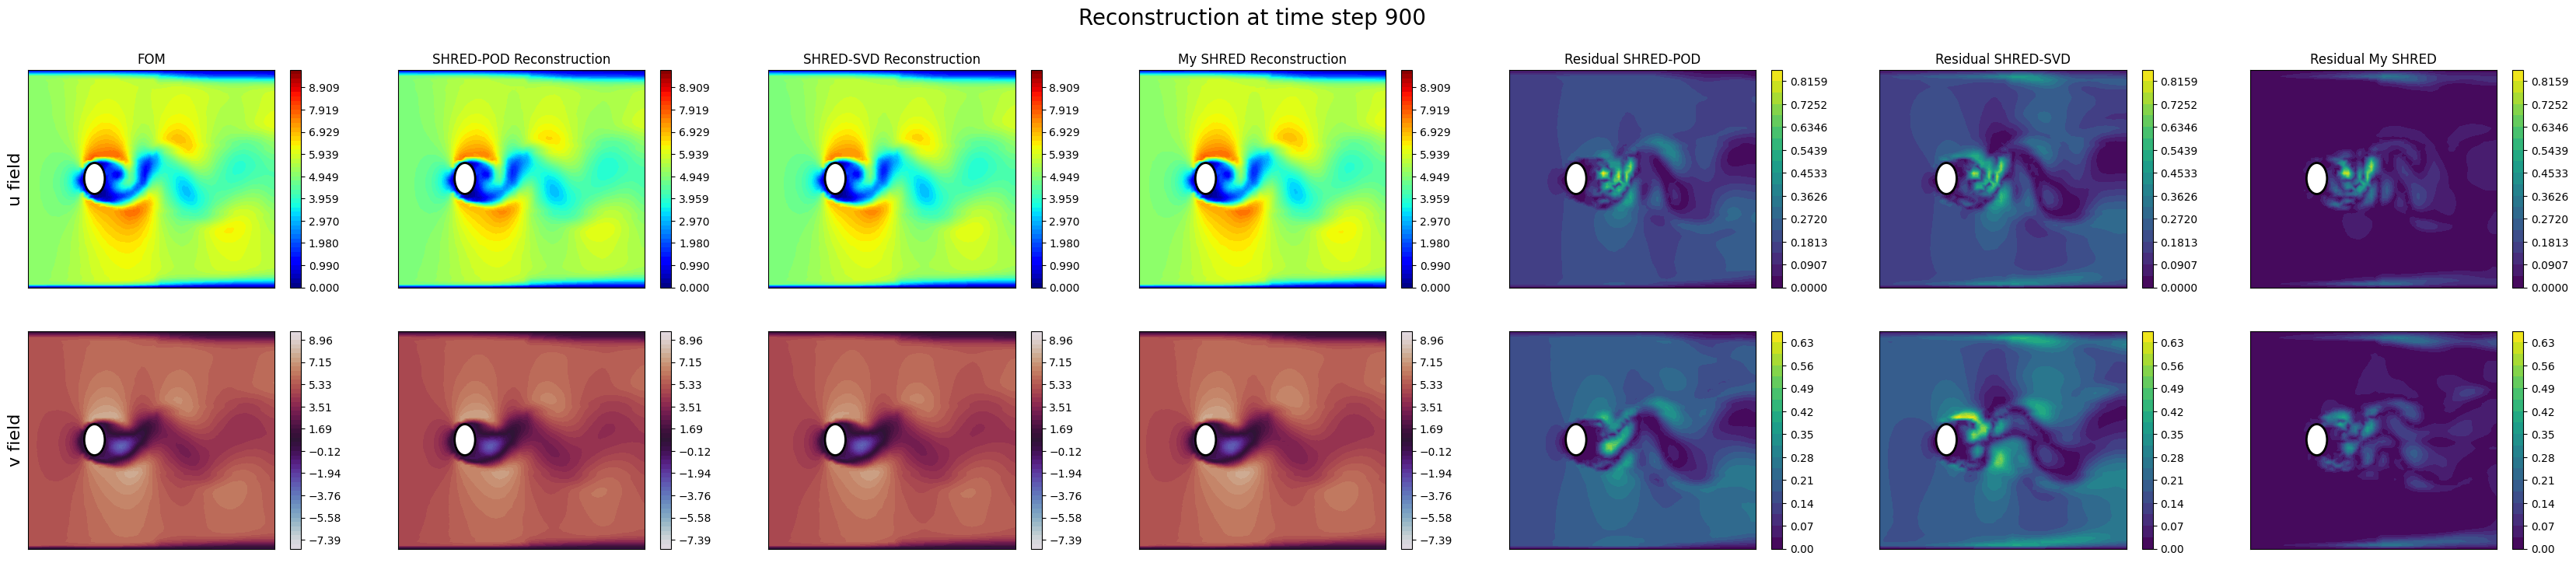

In [85]:
nrows = len(pod_test_reconstruction.keys())
ncols = 7

import matplotlib.pyplot as plt

cmaps = ['jet', 'twilight']

tt = 900
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 4 * nrows))

for field_i, field in enumerate(pod_test_reconstruction.keys()):

    levels = np.linspace(snapshots_np[field][manager_pod.test_indices[0]].min(), snapshots_np[field][manager_pod.test_indices[0]].max(), 50)
    
    fom = snapshots_np[field][manager_pod.test_indices[0], tt, :] # there is only one test case
    rec_pod_shred = pod_test_reconstruction[field][0, tt, :]
    rec_svd_shred = svd_test_reconstrunction[field][:, tt]
    rec_my_shred = my_shred_test_reconstrunction[field][:, tt]

    residual_pod_shred = np.abs(fom - rec_pod_shred)
    residual_svd_shred = np.abs(fom - rec_svd_shred)
    residual_my_shred = np.abs(fom - rec_my_shred)

    res_levels = np.linspace(0, max(residual_pod_shred.max(), residual_svd_shred.max(), residual_my_shred.max()), 20)

    # FOM
    c = axs[field_i, 0].tricontourf(nodes[:, 0], nodes[:, 1], fom, levels=levels, cmap=cmaps[field_i])
    create_circle(axs[field_i, 0])
    cbar = fig.colorbar(c, ax=axs[field_i, 0])

    # SHRED-POD
    c = axs[field_i, 1].tricontourf(nodes[:, 0], nodes[:, 1], rec_pod_shred, levels=levels, cmap=cmaps[field_i])
    create_circle(axs[field_i, 1])
    cbar = fig.colorbar(c, ax=axs[field_i, 1])

    # SHRED-SVD
    c = axs[field_i, 2].tricontourf(nodes[:, 0], nodes[:, 1], rec_svd_shred, levels=levels, cmap=cmaps[field_i])
    create_circle(axs[field_i, 2])
    cbar = fig.colorbar(c, ax=axs[field_i, 2])

    # My SHRED
    c = axs[field_i, 3].tricontourf(nodes[:, 0], nodes[:, 1], rec_my_shred, levels=levels, cmap=cmaps[field_i])
    create_circle(axs[field_i, 3])
    cbar = fig.colorbar(c, ax=axs[field_i, 3])

    # Residual - SHRED-POD
    c = axs[field_i, 4].tricontourf(nodes[:, 0], nodes[:, 1], residual_pod_shred, levels=res_levels, cmap='viridis')
    create_circle(axs[field_i, 4])
    cbar = fig.colorbar(c, ax=axs[field_i, 4])

    # Residual - SHRED-SVD
    c = axs[field_i, 5].tricontourf(nodes[:, 0], nodes[:, 1], residual_svd_shred, levels=res_levels, cmap='viridis')
    create_circle(axs[field_i, 5])
    cbar = fig.colorbar(c, ax=axs[field_i, 5])

    # Residual - My SHRED
    c = axs[field_i, 6].tricontourf(nodes[:, 0], nodes[:, 1], residual_my_shred, levels=res_levels, cmap='viridis')
    create_circle(axs[field_i, 6])
    cbar = fig.colorbar(c, ax=axs[field_i, 6])

    axs[field_i, 0].set_ylabel(f'{field} field', fontsize=16)

axs[0,0].set_title('FOM')
axs[0,1].set_title('SHRED-POD Reconstruction')
axs[0,2].set_title('SHRED-SVD Reconstruction')
axs[0,3].set_title('My SHRED Reconstruction')
axs[0,4].set_title('Residual SHRED-POD')
axs[0,5].set_title('Residual SHRED-SVD')
axs[0,6].set_title('Residual My SHRED')

for ax in axs.ravel():
    ax.set_xticks([])
    ax.set_yticks([])

fig.suptitle('Reconstruction at time step {}'.format(tt), fontsize=20)